 # Lab 6



 Grover's Search

 ## Task 1


 Simple Password Cracking with Grover's Algorithm


 Scenario: We have a 3-bit password (0-7) and we know its hash.

 We want to find which password produces that hash.


 For simplicity, we'll use a toy hash function:

 `hash(x) = (3*x + 5) mod 8` 


 Target: Find x where hash(x) = 5

 Answer: hash(0) = (3*0 + 5) mod 8 = 5, so password is 0

In [10]:
def toy_hash(x):
    """Hash function with unique preimages: (3*x + 5) mod 8."""
    return (3 * x + 5) % 8



In [11]:
# Setup
n_qubits = 3  # 3-bit password (values 0-7)
target_hash = 5  # The hash value we want to find a pre-image for



In [12]:
def classical_preimage_search():
    """Classically search for a pre-image of the target hash."""
    for x in range(8):
        print(f"h({x}) = {toy_hash(x)}")
        if toy_hash(x) == target_hash:
            return x
    return None


actual_password = classical_preimage_search()



h(0) = 5


In [13]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit.circuit.library import MCMTGate, ZGate
from qiskit_aer import AerSimulator
import numpy as np


In [14]:
def create_oracle(n_qubits, target_hash):
    """
    Create an oracle that marks states x where hash(x) == target_hash.
    This implements: hash(x) = (3*x + 5) mod 8

    Hint: You need ancilla qubits to compute the hash and check equality.
    """

    # n_qubits for input, n_qubits for hash output, 1 ancilla for phase kickback
    total_qubits = n_qubits + n_qubits + 1
    oracle = QuantumCircuit(total_qubits, name="Oracle")

    input_qubits = list(range(n_qubits))
    hash_qubits = list(range(n_qubits, n_qubits + n_qubits))
    phase_qubit = 2 * n_qubits

    # Step 1: Compute hash(x) = (3*x + 5) mod 8
    # TODO: Multiply by 3. HINT: 3*x = 2*x + x, so use CNOTs for left shift plus addition
    for i in range(n_qubits - 1):
        oracle.cx(input_qubits[i], hash_qubits[i + 1])  # Left shift by 1 (multiply by 2)
    for i in range(n_qubits):
        oracle.cx(input_qubits[i], hash_qubits[i])  # Add x


    # TODO: Add 5. HINT: Use X gates to add constants in binary (5 = 101 in binary)
    oracle.x(hash_qubits[0])  # Add 1 (2^0)
    oracle.x(hash_qubits[2])  # Add 4 (2^2)

    # Step 2: Check if hash(x) == target_hash
    target_binary = format(target_hash, f"0{n_qubits}b")

    # Flip qubits where target bit is 0 (so we match on |111...>)
    for i, bit in enumerate(target_binary):
        # TODO: Update here
        if bit == '0':
            oracle.x(hash_qubits[i])
        pass 

    # TODO: Mark the state with multi-controlled NOT
    oracle.mcx(hash_qubits, phase_qubit)

    # Unflip the checking bits
    for i, bit in enumerate(target_binary):
        # TODO: Update  here
        if bit == '0':
            oracle.x(hash_qubits[i])
        pass

    # Step 3: Uncompute hash to clean up ancilla
    # TODO: Reverse the hash computation steps
    # Un-add 5
    oracle.x(hash_qubits[0])  # Remove 1 (2^0)
    oracle.x(hash_qubits[2])  # Remove 4 (2^2)

    return oracle



In [15]:
def create_diffusion(n_qubits):
    """Create diffusion operator (inversion about average)"""
    diffusion = QuantumCircuit(n_qubits, name="Diffusion")

    # TODO: Implement the diffusion operator

    # Step 1: Apply H to all qubits
    diffusion.h(range(n_qubits))


    # Step 2: Apply X to all qubits
    diffusion.x(range(n_qubits))


    # Step 3: Multi-controlled Z (using ancilla if needed)
    diffusion.h(n_qubits - 1)  # Change last qubit to |-> basis
    diffusion.mcx(list(range(n_qubits - 1)), n_qubits - 1)  # Multi-controlled NOT
    diffusion.h(n_qubits - 1)  # Change back to |0>/<1> basis





    # Step 4: Apply X to all qubits
    diffusion.x(range(n_qubits))


    # Step 5: Apply H to all qubits
    diffusion.h(range(n_qubits))


    return diffusion



In [16]:
# Calculate number of Grover iterations
N = 2**n_qubits
optimal_iterations = int(np.pi / 4 * np.sqrt(N)) # Since there's 1 solution, otherwise use N/M, where M is the number of solutions
print(f"Optimal Grover iterations: {optimal_iterations}")



Optimal Grover iterations: 2


Note: you may need to restart the kernel to use updated packages.


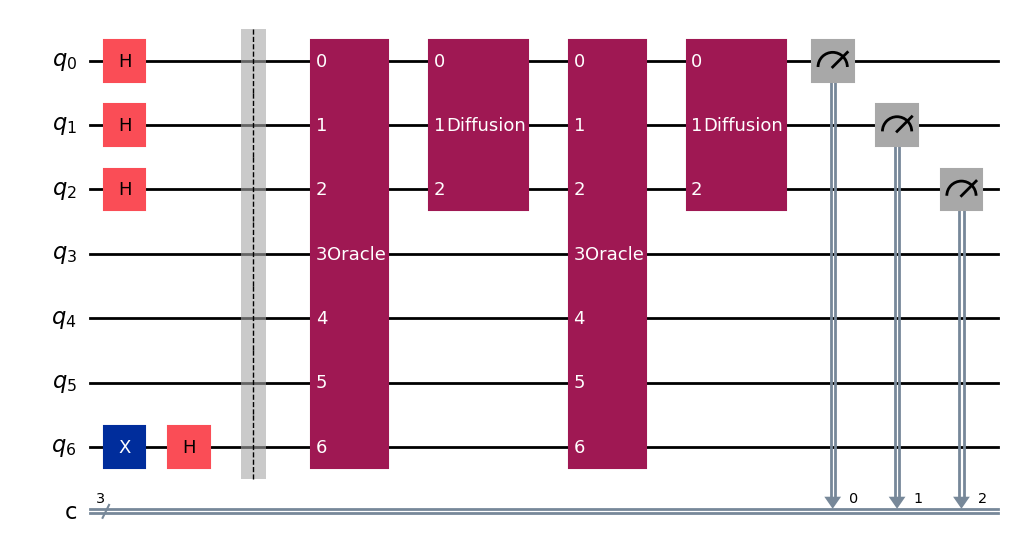

In [17]:
%pip install pylatexenc

# Build Grover circuit

total_qubits = n_qubits + n_qubits + 1  # Input qubits + hash qubits + ancilla
qr = QuantumRegister(total_qubits, "q")
cr = ClassicalRegister(n_qubits, "c")  # Only measure the input qubits

qc = QuantumCircuit(qr, cr)

# TODO: Initialize input qubits to superposition
qc.h(range(n_qubits))  # Input qubits in superposition


# TODO: Initialize phase qubit to |-⟩ for phase kickback
phase_qubit = 2 * n_qubits
qc.x(phase_qubit)
qc.h(phase_qubit)

qc.barrier()

# Grover iterations
oracle = create_oracle(n_qubits, target_hash)
diffusion = create_diffusion(n_qubits)

for _ in range(optimal_iterations):
    # TODO: Apply oracle and diffusion
    qc.append(oracle.to_gate(), range(total_qubits))
    qc.append(diffusion.to_gate(), range(n_qubits))
    pass

# TODO: Measure input qubits
qc.measure(range(n_qubits), range(n_qubits))
qc.draw("mpl")




In [18]:
# Simulate the circuit
simulator = AerSimulator()
job = simulator.run(transpile(qc, simulator), shots=4096)
result = job.result()
counts = result.get_counts()

sorted_counts = sorted(counts.items(), key=lambda x: x[1], reverse=True)
for state, count in sorted_counts:
    percentage = count / 4096 * 100
    password_guess = int(state, 2)
    hash_value = toy_hash(password_guess)
    marker = "✓✓✓" if password_guess == actual_password else ""
    print(
        f"  {state} (password={password_guess}): {count:4d} shots ({percentage:5.1f}%) - h({password_guess})={hash_value} {marker}"
    )

# Find the most likely password guess
most_common = max(counts, key=counts.get)
found_password = int(most_common, 2)

print(
    f"\nMost likely password guess: {found_password} (h({found_password})={toy_hash(found_password)})"
)


  000 (password=0): 1884 shots ( 46.0%) - h(0)=5 ✓✓✓
  011 (password=3):  324 shots (  7.9%) - h(3)=6 
  110 (password=6):  320 shots (  7.8%) - h(6)=7 
  111 (password=7):  318 shots (  7.8%) - h(7)=2 
  001 (password=1):  316 shots (  7.7%) - h(1)=0 
  100 (password=4):  315 shots (  7.7%) - h(4)=1 
  101 (password=5):  311 shots (  7.6%) - h(5)=4 
  010 (password=2):  308 shots (  7.5%) - h(2)=3 

Most likely password guess: 0 (h(0)=5)
